# 4

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from torchsummary import summary
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
path = 'W:\\datasets\\asbestos\\line-segmentation\\'
os.listdir(path)

['aug_images_224',
 'aug_masks_224',
 'images',
 'images_encoder',
 'images_encoder0',
 'images_encoder1',
 'macro_fullsize.xml',
 'masks',
 'masks_encoder',
 'v1']

In [4]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'aug_images_224':
        img_pathes = pathes
    elif folder == 'aug_masks_224':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [5]:
len(img_pathes)

500

In [6]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
masks = []
for mask in lbl_pathes:
    masks.append(T(Image.open(mask)))

In [8]:
answers = []
for i in range(len(lbl_pathes)):
    if sum(masks[i].view(-1)).item():
        answers.append(1)
    else:
        answers.append(0)

In [9]:
import torch
from torch.utils import data


class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'aug_images_224':
                img_pathes = pathes
            elif folder == 'aug_masks_224':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))

        if subset == 'train':
            self.items = items[: int(0.5 * len(items))]
        elif subset == 'valid':
            self.items = items[int(0.5 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name)#.convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        lbl = int(bool(sum(mask.view(-1)).item()))
        
        return image, lbl

In [10]:
data = Dataset(path, subset='valid', transform=T)

In [11]:
img, msk = data[0]
msk

0

In [12]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)

In [13]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)

lbl:     tensor([1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])


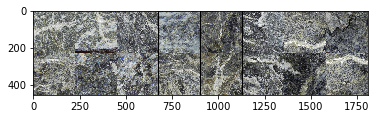

In [14]:
images, lbl = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print("lbl:    ", lbl)


In [15]:
from torchvision.models import resnet50
import torch.nn.functional as F

class Net(nn.Module): #Multi-task learning
    def __init__(self, net='resnet50', pretrained=True):
        super(Net, self).__init__()
        self.net = net
            
            
        if self.net == 'resnet34':
            self.model = models.resnet34(pretrained)
            self.model.asbestos_cls = nn.Linear(512, 2)

        elif self.net == 'resnet50':
            self.model = models.resnet50(pretrained) # initialize the resnet50
            self.model.asbestos_cls = nn.Linear(2048, 2)


    def forward(self, x):
        if (self.net == 'resnet50') or (self.net == 'resnet34'):
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x) # without last fully connected(2048, 1000) layer
            x = x.view(x.size(0), -1)
            x = self.model.asbestos_cls(x)

        


        
        return x

In [16]:
model = Net(net='resnet34', pretrained=True).to(device)

In [17]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)

In [18]:
epochs = 10
x = list(range(1, epochs + 1))
loss_list = []
val_loss_list = []
accuracy_list = []
v_accuracy_list = []

In [19]:
%%time
print("epoch|loss |val_loss|acc  |v_acc|")
for epoch in range(epochs): # entire dataset is passed forward and backward through the nn
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train(True)

    
            running_loss = 0
            correct = 0
            total = 0
    
    
    
            for batch_idx, training_batch in enumerate(train_loader):        
                inputs, labels = training_batch[0].to(device), training_batch[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward propagation
                outputs = model(inputs)

                loss = loss_function(outputs, labels)

                #backward propagation
                loss.backward()

                # Update the parameters(weight,bias)
                optimizer.step()

                running_loss += loss.item()# .data
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        elif phase == 'valid':
            with torch.no_grad():
                model.train(False)
                validation_loss = 0
                v_correct = 0
                v_total = 0


                for batch_idx, valid_batch in enumerate(valid_loader):
                    val_inputs, val_labels = valid_batch[0].to(device), valid_batch[1].to(device)
                    val_outputs = model(val_inputs)

                    # validation loss
                    val_loss = loss_function(val_outputs, val_labels)
                    validation_loss += val_loss.item()

                    # validation accuracy
                    _, predicted = torch.max(val_outputs.data, 1)
                    v_total += val_labels.size(0)
                    v_correct += (predicted == val_labels).sum().item()
                                    

        
    print('%5d|%.3f| %.3f  |%.3f|%.3f|' %
          (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
           correct / total, v_correct / v_total
           ))          

            

                    
    loss_list.append(running_loss / len(train_loader))
    val_loss_list.append(validation_loss / len(valid_loader))

    accuracy_list.append(correct / total)
    v_accuracy_list.append(v_correct / v_total)

epoch|loss |val_loss|acc  |v_acc|
    1|1.061| 0.981  |0.260|0.400|
    2|0.880| 0.780  |0.332|0.480|
    3|0.727| 0.650  |0.488|0.628|
    4|0.627| 0.611  |0.656|0.640|
    5|0.586| 0.610  |0.732|0.648|
    6|0.543| 0.615  |0.780|0.636|
    7|0.531| 0.618  |0.788|0.644|
    8|0.540| 0.620  |0.784|0.636|
    9|0.518| 0.623  |0.792|0.644|
   10|0.501| 0.622  |0.800|0.648|
Wall time: 28min 40s


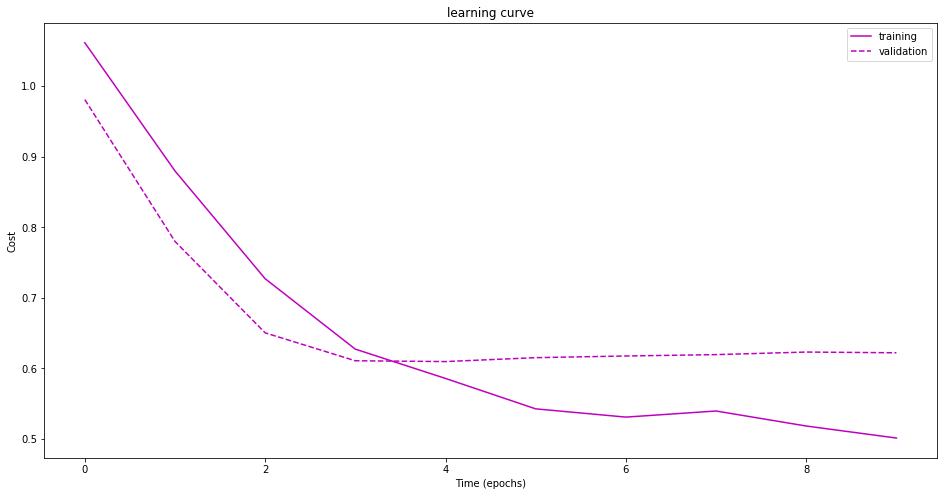

In [22]:
plt.figure(figsize=(16,8))
plt.title("learning curve")
plt.plot(loss_list,'m', label= 'training')
plt.plot(val_loss_list,'m--', label= 'validation')
plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.legend();

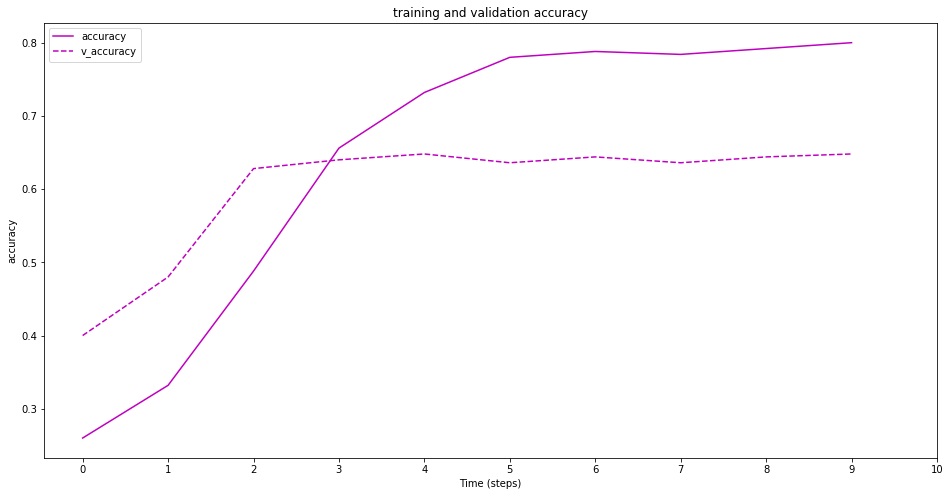

In [23]:
plt.figure(figsize=(16,8))
plt.title("training and validation accuracy")
plt.plot(accuracy_list, 'm', label = 'accuracy')
plt.plot(v_accuracy_list, 'm--', label = 'v_accuracy')


plt.xticks(range(0, 11))
plt.xlabel("Time (steps)")
plt.ylabel("accuracy")
plt.legend();